In [7]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def rgb_img(path_img):
  img = cv2.imread(path_img)
  img_rgb = cv2.cvtColor(img ,cv2.COLOR_BGR2RGB)
  return img_rgb

def imshow(img, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.show()

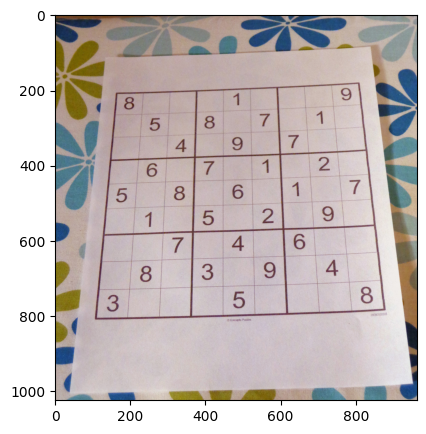

In [13]:
sudoku_img = rgb_img("/content/drive/MyDrive/My_data/sudoku (1).jpg")
imshow(sudoku_img)

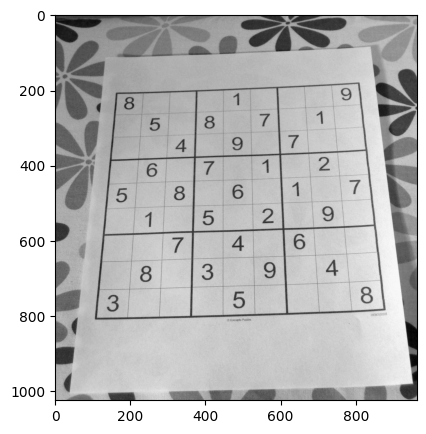

In [16]:
img_gray = cv2.cvtColor(sudoku_img, cv2.COLOR_RGB2GRAY)
imshow(img_gray, figsize=(5, 5))

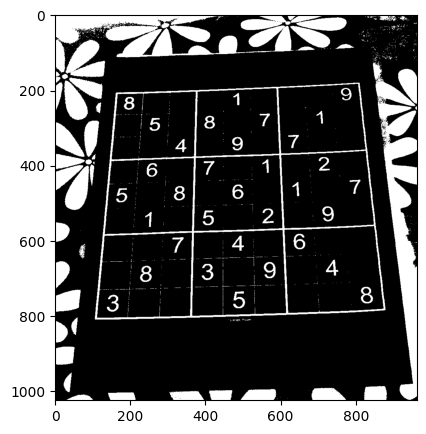

In [17]:
_, img_bin = cv2.threshold(img_gray, 0, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
imshow(img_bin, figsize=(5, 5))

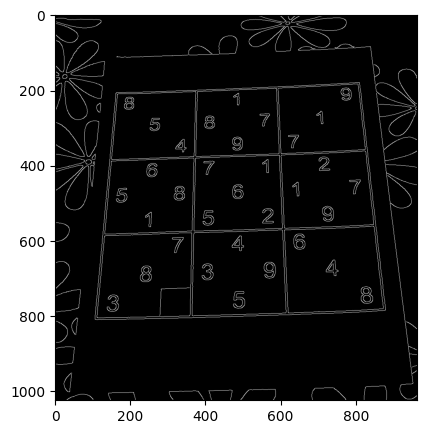

In [18]:
blur = cv2.GaussianBlur(sudoku_img, (5, 5), 0)
edges = cv2.Canny(blur, 75, 200)
imshow(edges, figsize=(5, 5))

In [19]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect


In [20]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    pts = pts.reshape(4, 2)
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped

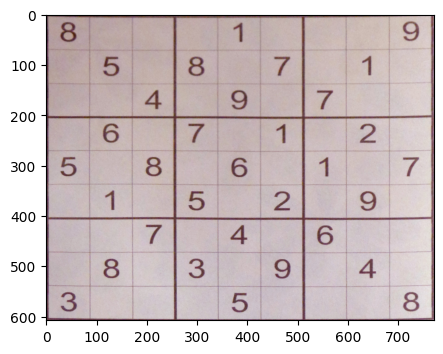

In [21]:
def find_contours(edges, img):
    contours, rel = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    sudoku_Contour = None
    for c in contours:
        length = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.01 * length, True)
        if len(approx) == 4:
            sudoku_Contour = approx
            break

    return sudoku_Contour

sudoku_Contour = find_contours(edges,sudoku_img )
sudoku = four_point_transform(sudoku_img, sudoku_Contour)
imshow(sudoku)

In [23]:
def detect_connected_components(img, w_range=None, h_range=None):

    # convert image to rgb
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    # convert image to gray
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # convert gray image to binary
    t, img_bin = cv2.threshold(img_gray, 0, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)


    # detect connected components
    components = cv2.connectedComponentsWithStats(img_bin, connectivity=4)
    (nLabels, labels, stats, centroids) = components
    centroids = centroids.astype(int)

    # copy image to avoid drawing on the original image
    img1 = img_rgb.copy()

    # loop through components
    for i in range(1, nLabels):
        x, y, w, h, area = stats[i]
        (cx, cy) = centroids[i]

        # by default, there is no limit for width or height
        acceptWidth = True
        acceptHeight = True

        # check the width, and height are within range (if defined)
        if w_range:
            acceptWidth = (w > w_range[0] and w < w_range[1])
        if h_range:
            acceptHeight = (h > h_range[0] and h < h_range[1])

        # draw location if width and height are accepted
        if acceptWidth and acceptHeight:
            cv2.rectangle(img1, (x, y), (x+w, y+h), (0, 255, 0), 3)
            cv2.circle(img1, (cx, cy), 4, (255, 255, 255), -1)

    # show image with locations of detected components
    imshow(img1, figsize=(5, 5))

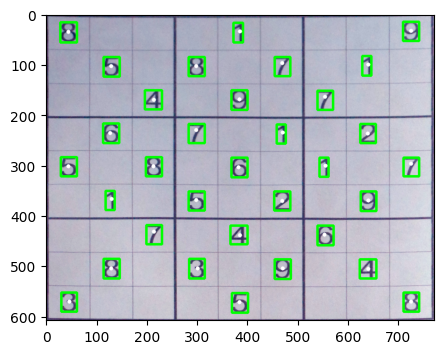

In [24]:
detect_connected_components(sudoku, w_range=(15, 50), h_range=(20, 50))